<a href="https://colab.research.google.com/github/JadynVigil/ML-on-TaxiData/blob/main/ML_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyspark

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegressionCoursework") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c00bf2f757a8f844546b0bd79643c9207edff3a8fb12df250728420cf2a0200a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


df = spark.read.csv("/content/drive/MyDrive/Data Sets/original_cleaned_nyc_taxi_data_2018.csv", inferSchema= True, header = True)


df.show(20)

# more info
print(df.rdd.getNumPartitions())
print((df.count(), len(df.columns)))
df.columns

Mounted at /content/drive
+---+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+----+-----+---+-----------+-----------+------------------+-----------------------+
|_c0|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|year|month|day|day_of_week|hour_of_day|     trip_duration|calculated_total_amount|
+---+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+----+-----+---+-----------+-----------+------------------+-----------------------+
|  3|        16.97|        1|                 N|           1|       49.5|  0.0|    0.5|      5.61|        5.76|          0.3|       61.67|               231|                138|2018|    3| 29|  

['_c0',
 'trip_distance',
 'rate_code',
 'store_and_fwd_flag',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'imp_surcharge',
 'total_amount',
 'pickup_location_id',
 'dropoff_location_id',
 'year',
 'month',
 'day',
 'day_of_week',
 'hour_of_day',
 'trip_duration',
 'calculated_total_amount']

In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- calculated_total_amount: double (nullable = true)



In [ ]:
#Check for missing values
from pyspark.sql.functions import col, sum

missing_values = [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]

values_missing = df.select(missing_values)
values_missing.show()

+---+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+----+-----+---+-----------+-----------+-------------+-----------------------+
|_c0|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|year|month|day|day_of_week|hour_of_day|trip_duration|calculated_total_amount|
+---+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+----+-----+---+-----------+-----------+-------------+-----------------------+
|  0|            0|        0|                 0|           0|          0|    0|      0|         0|           0|            0|           0|                 0|                  0|   0|    0|  0|          0|          0|            0|     

In [ ]:
# drop columns
final_df = df.drop("_c0", "rate_code", "store_and_fwd_flag","payment_type", "pickup_location_id", "dropoff_location_id", "year", "month", "day", "day_of_week", "hour_of_day", "trip_duration", "calculated_total_amount")
final_df.show(10)

+-------------+-----------+-----+-------+----------+------------+-------------+------------+
|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|
+-------------+-----------+-----+-------+----------+------------+-------------+------------+
|        16.97|       49.5|  0.0|    0.5|      5.61|        5.76|          0.3|       61.67|
|        14.45|       45.5|  0.0|    0.5|     10.41|        5.76|          0.3|       62.47|
|         11.6|       42.0|  0.0|    0.5|     14.57|        5.76|          0.3|       63.13|
|          5.1|       26.5|  1.0|    0.5|      5.65|         0.0|          0.3|       33.95|
|        11.11|       45.5|  1.0|    0.5|     10.61|        5.76|          0.3|       63.67|
|         9.54|       41.0|  1.0|    0.5|      9.71|        5.76|          0.3|       58.27|
|         10.0|       38.5|  1.0|    0.5|      8.05|         0.0|          0.3|       48.35|
|          9.8|       38.5|  1.0|    0.5|      6.94|        5.76|     

In [ ]:
# combine features into a single vector column using VectorAssembler
assembler = VectorAssembler(inputCols=["trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "imp_surcharge"],
                            outputCol="features")

dataset = assembler.transform(final_df)

dataset = dataset.select("features", "total_amount")

dataset.show(5, truncate=False)

+-----------------------------------+------------+
|features                           |total_amount|
+-----------------------------------+------------+
|[16.97,49.5,0.0,0.5,5.61,5.76,0.3] |61.67       |
|[14.45,45.5,0.0,0.5,10.41,5.76,0.3]|62.47       |
|[11.6,42.0,0.0,0.5,14.57,5.76,0.3] |63.13       |
|[5.1,26.5,1.0,0.5,5.65,0.0,0.3]    |33.95       |
|[11.11,45.5,1.0,0.5,10.61,5.76,0.3]|63.67       |
+-----------------------------------+------------+
only showing top 5 rows



In [ ]:
# Normalize the data by scaling
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')

scaler_model = scaler.fit(dataset)
data_scaled = scaler_model.transform(dataset)

data_scaled = data_scaled.select('scaledFeatures', 'total_amount')
data_scaled.show(5, truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                     |total_amount|
+-----------------------------------------------------------------------------------------------------------------------------------+------------+
|[2.884850263598151,0.6539783410641749,0.0,6.043060556946095,1.227546659284149,1.5353832540051882,80.12909813820313]                |61.67       |
|[2.456457649321938,0.6011316064327263,0.0,6.043060556946095,2.277853961345453,1.5353832540051882,80.12909813820313]                |62.47       |
|[1.9719660022238394,0.5548907136302089,0.0,6.043060556946095,3.188120289798583,1.5353832540051882,80.12909813820313]               |63.13       |
|[0.8669850527018603,0.35010961693334613,1.766231153223802,6.043060556946095,1.2362992201346599,0.0,80.12909813820313]

In [ ]:
# split data
train_data, test_data = data_scaled.randomSplit([0.7, 0.3], seed = 21)
train_data.show(5, truncate = False)

+-----------------------------------------------------+------------+
|scaledFeatures                                       |total_amount|
+-----------------------------------------------------+------------+
|(7,[0,1],[0.003399941383144551,0.03302920914465529]) |2.5         |
|(7,[0,1],[0.006799882766289102,0.9644529070239346])  |73.0        |
|(7,[0,1],[0.008499853457861377,0.792701019471727])   |60.0        |
|(7,[0,1],[0.016999706915722754,0.039635050973586355])|3.0         |
|(7,[0,1],[1.6829709846565526,0.9520339243855442])    |72.06       |
+-----------------------------------------------------+------------+
only showing top 5 rows



In [ ]:
# Apply Linear Regression
lr = LinearRegression(labelCol = 'total_amount', featuresCol = 'scaledFeatures', predictionCol = 'prediction')

lr_model = lr.fit(train_data)

lr_predictions = lr_model.transform(test_data)

lr_predictions.select('prediction', 'total_amount').show(10, truncate = False)

+------------------+------------+
|prediction        |total_amount|
+------------------+------------+
|45.85694523563021 |45.85       |
|56.46636085573803 |56.46       |
|67.25598305493278 |67.25       |
|65.30587898322983 |65.3        |
|96.98575809650276 |96.98       |
|70.26578657092618 |70.26       |
|73.06577431926492 |73.06       |
|70.26574826090093 |70.26       |
|117.35552549462263|117.35      |
|60.50353141329312 |60.5        |
+------------------+------------+
only showing top 10 rows



In [ ]:
#Access the coefficients and intercept of the model

coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(coefficients)
print(intercept)

[-0.00045071394966665753,75.69045601860002,0.5654997929993214,0.0821316680769739,4.571820353421394,3.7507155669407193,0.003801552090787258]
0.007303885437329494


In [ ]:
# Apply Lasso Regression
lasso = LinearRegression(labelCol = 'total_amount', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 1.0, regParam = 0.08) # lambda: tuning
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

lasso_predictions.select('prediction', 'total_amount').show(10, truncate = False)

+------------------+------------+
|prediction        |total_amount|
+------------------+------------+
|46.78928132227141 |45.85       |
|57.38318300433788 |56.46       |
|68.15681157639227 |67.25       |
|66.20977026818967 |65.3        |
|97.84170290606579 |96.98       |
|71.16224457007937 |70.26       |
|73.95799619211387 |73.06       |
|71.16224457007937 |70.26       |
|118.18079595636681|117.35      |
|60.9178118407672  |60.5        |
+------------------+------------+
only showing top 10 rows



In [ ]:
# Ridge
ridge = LinearRegression(labelCol = 'total_amount', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.08)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)
ridge_predictions.select('prediction', 'total_amount').show(10, truncate = False)

+------------------+------------+
|prediction        |total_amount|
+------------------+------------+
|45.94203562564247 |45.85       |
|56.56467148205804 |56.46       |
|67.35501001696201 |67.25       |
|65.41490932030548 |65.3        |
|97.03878366800255 |96.98       |
|70.37036888998053 |70.26       |
|73.16549886350602 |73.06       |
|70.37258292372735 |70.26       |
|117.38164578178241|117.35      |
|60.49580037239025 |60.5        |
+------------------+------------+
only showing top 10 rows



In [ ]:
# calculate MSE - Mean Squared Error
evaluator_mse = RegressionEvaluator(labelCol = 'total_amount', predictionCol = 'prediction', metricName = 'mse')
mse1 = evaluator_mse.evaluate(lr_predictions)
mse2 = evaluator_mse.evaluate(lasso_predictions)
mse3 = evaluator_mse.evaluate(ridge_predictions)

# calculate RMSE - Root of MSE
evaluator_rmse = RegressionEvaluator(labelCol = 'total_amount', predictionCol = 'prediction', metricName = 'rmse')
rmse1 = evaluator_rmse.evaluate(lr_predictions)
rmse2 = evaluator_rmse.evaluate(lasso_predictions)
rmse3 = evaluator_rmse.evaluate(ridge_predictions)

# calculate Root squared
evaluator_r2 = RegressionEvaluator(labelCol = 'total_amount', predictionCol = 'prediction', metricName = 'r2')
r2_mse1 = evaluator_r2.evaluate(lr_predictions)
r2_mse2 = evaluator_r2.evaluate(lasso_predictions)
r2_mse3 = evaluator_r2.evaluate(ridge_predictions)


print('Linear - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_mse1)
print('Lasso - MSE: ', mse2, ', RMSE: ', rmse2, ', R^2: ', r2_mse2)
print('Ridge - MSE: ', mse3, ', RMSE: ', rmse3, ', R^2: ', r2_mse3)

Linear - MSE:  0.0215439025742994 , RMSE:  0.14677841317543736 , R^2:  0.9999985222109227
Lasso - MSE:  0.07552638193691483 , RMSE:  0.2748206359371778 , R^2:  0.9999948193201352
Ridge - MSE:  0.07285183598182052 , RMSE:  0.2699107926367905 , R^2:  0.9999950027787627


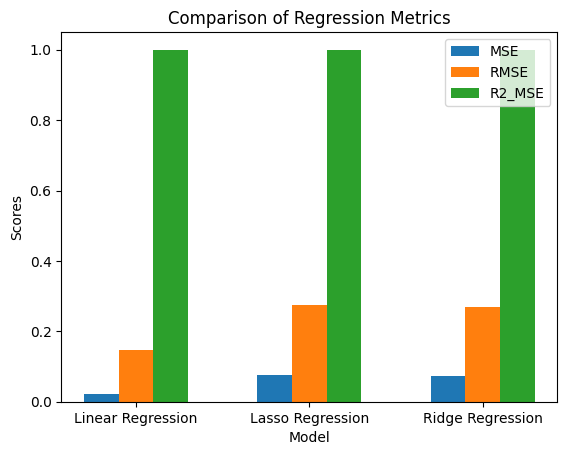

In [ ]:
#plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mse2, mse3]
rmse = [rmse1, rmse2, rmse3]
r2_mse = [r2_mse1, r2_mse2, r2_mse3]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_mse, width = bar_width, label = 'R2_MSE')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Linear Regression', 'Lasso Regression', 'Ridge Regression'])
plt.show()